In [64]:
# Importing required libraries
import pandas as pd

In [139]:
# Importing all the files
def import_files(filename, columns_to_keep):
    file_path = "C:\\Users\\Acer\\Desktop\\Dissertation\\mimic_kaggle\\mimic-iii-clinical-database-demo-1.4\\"
    filename = file_path + filename
    return pd.read_csv(filename, usecols = columns_to_keep)

admissions = import_files("admissions.csv", ["subject_id","hadm_id","admittime","dischtime","deathtime","admission_type",
                                            "diagnosis"])

# Files included
patients = import_files("patients.csv", ["subject_id","gender"])
icu_stays = import_files("icustays.csv", ["subject_id","hadm_id","icustay_id","intime","outtime"])
services = import_files("services.csv", ["subject_id","hadm_id","transfertime","prev_service","curr_service"])
# diagnoses_icd = import_files("diagnoses_icd.csv", ["subject_id","hadm_id","icd9_code"])
labevents = import_files("labevents.csv", ["subject_id","hadm_id","itemid","charttime","value"])

In [ ]:
""" Once the required files are imported, activity is labelled for each type of file """

In [140]:
# Melting df For admissions
admissions_melted_df = pd.melt(admissions, id_vars=['subject_id', 'hadm_id', 'admission_type'],
                   value_vars=['admittime', 'dischtime', 'deathtime'],
                   var_name='activity', value_name='timestamp')

# Function to determine activity
def determine_activity(row, original_df):
    if row['activity'] == 'admittime':
        return 'Hospital Admission'
    elif row['activity'] == 'dischtime':
        # Check if deathtime is equal to dischtime
        death_time = original_df.loc[(original_df['subject_id'] == row['subject_id']) & 
                                     (original_df['hadm_id'] == row['hadm_id']), 'deathtime'].values[0]
        if pd.notna(death_time) and death_time == row['timestamp']:
            return 'Dead'
        else:
            return 'Discharged from hospital'
    elif row['activity'] == 'deathtime' and pd.notna(row['timestamp']):
        return None
    else:
        return None

# Apply the function
admissions_melted_df['activity'] = admissions_melted_df.apply(determine_activity, axis=1, args=(admissions,))
# Filter out rows with None in activity
admissions_melted_df = admissions_melted_df[admissions_melted_df['activity'].notna()]
# Convert time to datetime
admissions_melted_df["timestamp"] = pd.to_datetime(admissions_melted_df["timestamp"])
admissions_melted_df = admissions_melted_df.sort_values(by = ["subject_id", "hadm_id","timestamp"])

print(admissions_melted_df.head(5))


     subject_id  hadm_id admission_type                  activity  \
0         10006   142345      EMERGENCY        Hospital Admission   
129       10006   142345      EMERGENCY  Discharged from hospital   
1         10011   105331      EMERGENCY        Hospital Admission   
130       10011   105331      EMERGENCY                      Dead   
2         10013   165520      EMERGENCY        Hospital Admission   

              timestamp  
0   2164-10-23 21:09:00  
129 2164-11-01 17:15:00  
1   2126-08-14 22:32:00  
130 2126-08-28 18:59:00  
2   2125-10-04 23:36:00  


In [141]:
# Melting df For ICU stays
icu_stays_melted_df = pd.melt(icu_stays, id_vars=['subject_id', 'hadm_id', 'icustay_id'],
                   value_vars=['intime', 'outtime'],
                   var_name='activity', value_name='timestamp')

# Declaring activity
icu_stays_melted_df['activity'] = icu_stays_melted_df['activity'].apply(
    lambda x: 'ICU Admission' if x == 'intime' else ('ICU Exit' if x == 'outtime' else x)
)

icu_stays_melted_df["timestamp"] = pd.to_datetime(icu_stays_melted_df["timestamp"])
# Sorting the df by id and time
icu_stays_melted_df = icu_stays_melted_df.sort_values(by = ["subject_id", "hadm_id","timestamp"])
print(icu_stays_melted_df.head(5))


     subject_id  hadm_id  icustay_id       activity           timestamp
0         10006   142345      206504  ICU Admission 2164-10-23 21:10:15
136       10006   142345      206504       ICU Exit 2164-10-25 12:21:07
1         10011   105331      232110  ICU Admission 2126-08-14 22:34:00
137       10011   105331      232110       ICU Exit 2126-08-28 18:59:00
2         10013   165520      264446  ICU Admission 2125-10-04 23:38:00


In [142]:
# For services
services['activity'] = services['curr_service']
melted_services_df = services.loc[:, ["subject_id", "hadm_id", "activity", "transfertime"]]
melted_services_df = melted_services_df.rename(columns = {"transfertime" : "timestamp"})
melted_services_df["timestamp"] = pd.to_datetime(melted_services_df["timestamp"])
melted_services_df = melted_services_df.sort_values(by = ["subject_id", "hadm_id","timestamp"])

print(melted_services_df.head(4))
print(melted_services_df.dtypes)


   subject_id  hadm_id activity           timestamp
0       10006   142345      MED 2164-10-23 21:10:15
1       10011   105331      MED 2126-08-14 22:34:00
2       10013   165520      MED 2125-10-04 23:38:00
3       10017   199207      MED 2149-05-26 17:21:09
subject_id             int64
hadm_id                int64
activity              object
timestamp     datetime64[ns]
dtype: object


In [143]:
# For labevents
labevents['activity'] = "Test recorded"
melted_labevents_df = labevents.loc[:, ["subject_id", "hadm_id", "itemid", "activity", "charttime"]]
melted_labevents_df = melted_labevents_df.rename(columns = {"charttime" : "timestamp"})
melted_labevents_df["timestamp"] = pd.to_datetime(melted_labevents_df["timestamp"])
# Removing the NAN rows from hadm_id
melted_labevents_df = melted_labevents_df.dropna(subset=["hadm_id"])
melted_labevents_df = melted_labevents_df.astype({"hadm_id":"int"})
melted_labevents_df = melted_labevents_df.sort_values(by = ["subject_id", "hadm_id","timestamp"])


print(melted_labevents_df)
print(melted_labevents_df.dtypes)

       subject_id  hadm_id  itemid       activity           timestamp
633         10006   142345   50813  Test recorded 2164-10-23 17:33:00
634         10006   142345   50861  Test recorded 2164-10-23 17:38:00
635         10006   142345   50862  Test recorded 2164-10-23 17:38:00
636         10006   142345   50863  Test recorded 2164-10-23 17:38:00
637         10006   142345   50868  Test recorded 2164-10-23 17:38:00
...           ...      ...     ...            ...                 ...
76069       44228   103379   51250  Test recorded 2170-12-24 04:09:00
76070       44228   103379   51265  Test recorded 2170-12-24 04:09:00
76071       44228   103379   51277  Test recorded 2170-12-24 04:09:00
76072       44228   103379   51279  Test recorded 2170-12-24 04:09:00
76073       44228   103379   51301  Test recorded 2170-12-24 04:09:00

[61812 rows x 5 columns]
subject_id             int64
hadm_id                int32
itemid                 int64
activity              object
timestamp     date

In [144]:
# Concatenating all the dfs
# all_dfs = [admissions_melted_df, icu_stays_melted_df, melted_services_df, melted_labevents_df]
all_dfs = [admissions_melted_df, icu_stays_melted_df, melted_services_df]

final_event_log = pd.concat(all_dfs, ignore_index = True)

final_event_log = final_event_log.sort_values(by = ["subject_id", "hadm_id", "timestamp"])

# Joining the final df with patients df to get genders
final_event_log = pd.merge(final_event_log, patients, how = "inner", on = ["subject_id"])

print(final_event_log.head(5))
print(final_event_log["icustay_id"].isna().sum())
print(final_event_log["admission_type"].isna().sum())


   subject_id  hadm_id admission_type                  activity  \
0       10006   142345      EMERGENCY        Hospital Admission   
1       10006   142345            NaN             ICU Admission   
2       10006   142345            NaN                       MED   
3       10006   142345            NaN                  ICU Exit   
4       10006   142345      EMERGENCY  Discharged from hospital   

            timestamp  icustay_id gender  
0 2164-10-23 21:09:00         NaN      F  
1 2164-10-23 21:10:15    206504.0      F  
2 2164-10-23 21:10:15         NaN      F  
3 2164-10-25 12:21:07    206504.0      F  
4 2164-11-01 17:15:00         NaN      F  
421
435


In [145]:
""" EDA """
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics description
print(final_event_log.describe())

# Sum of null values for each column
print(final_event_log.isnull().sum())


         subject_id        hadm_id                      timestamp  \
count    693.000000     693.000000                            693   
mean   28081.264069  153055.603175  2153-05-23 12:05:26.808081408   
min    10006.000000  100375.000000            2102-08-29 03:15:39   
25%    10089.000000  128293.000000            2127-10-28 12:50:00   
50%    40310.000000  157609.000000            2150-08-07 21:41:28   
75%    42199.000000  174997.000000            2180-03-04 21:20:36   
max    44228.000000  199395.000000            2202-10-11 16:30:00   
std    16003.978557   28013.714114                            NaN   

          icustay_id  
count     272.000000  
mean   250980.470588  
min    201006.000000  
25%    224359.250000  
50%    250055.000000  
75%    277279.250000  
max    298685.000000  
std     28402.577078  
subject_id          0
hadm_id             0
admission_type    435
activity            0
timestamp           0
icustay_id        421
gender              0
dtype: int64


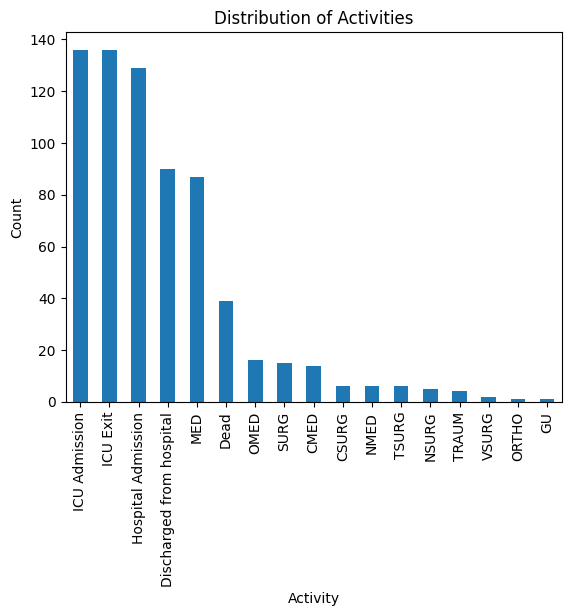

In [146]:
# Number of occurrences of each unique value
activity_counts = final_event_log['activity'].value_counts()
activity_counts.plot(kind='bar')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Distribution of Activities')
plt.show()

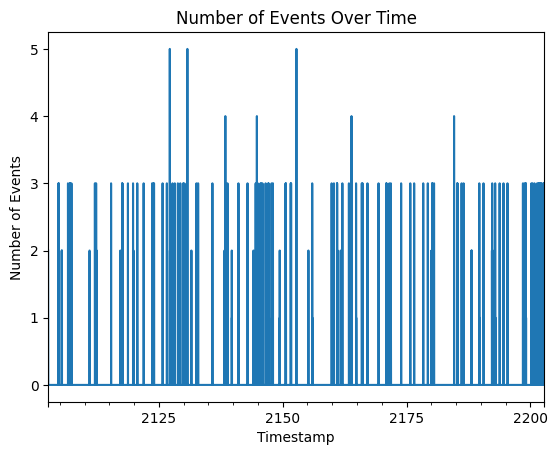

In [147]:
# Plot the number of events over time
final_event_log.set_index('timestamp').resample('D').size().plot()
plt.xlabel('Timestamp')
plt.ylabel('Number of Events')
plt.title('Number of Events Over Time')
plt.show()

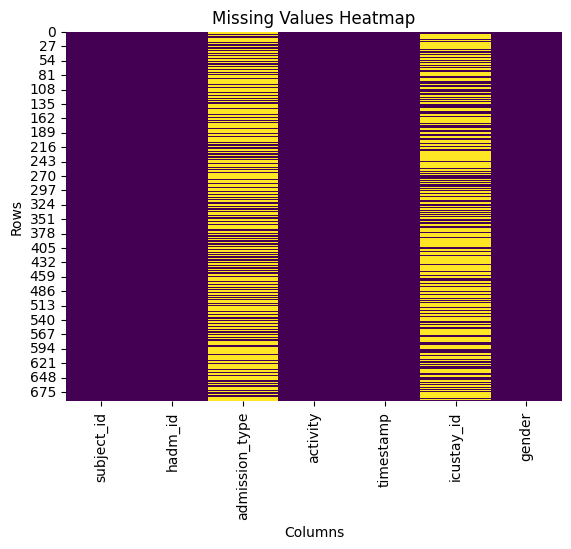

'The Null values in admission_type and icustay_id is due to events happening between admissiona ti hospitala and transfer \nto icu. The admission type is null when the patient moves to icu and icustay_id becomes null when vive versa'

In [148]:
# Plot the missing values
sns.heatmap(final_event_log.isnull(), cbar=False, cmap='viridis')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Missing Values Heatmap')
plt.show()

"""The Null values in admission_type and icustay_id is due to events happening between admissiona ti hospitala and transfer 
to icu. The admission type is null when the patient moves to icu and icustay_id becomes null when vive versa"""

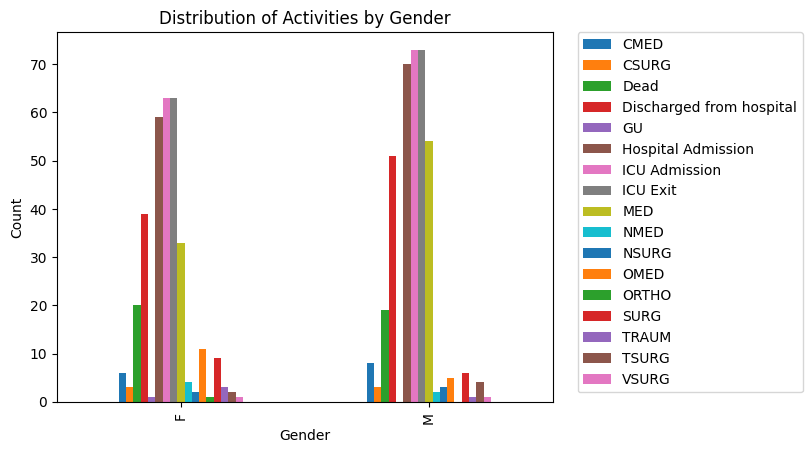

Index([10006, 10006, 10006, 10006, 10006, 10011, 10011, 10011, 10011, 10011,
       ...
       44222, 44222, 44222, 44222, 44222, 44228, 44228, 44228, 44228, 44228],
      dtype='int64', name='subject_id', length=693)


In [149]:
# Grouping by gender and activity and count the number of occurrences
gender_activity_counts = final_event_log.groupby(['gender', 'activity']).size().unstack()

# Plot the counts
ax = gender_activity_counts.plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Activities by Gender')

# Move the legend to the right of the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

# Adding index in subject_id column
final_event_log.set_index(['subject_id'], inplace=True)

In [150]:
""" Process mining """
# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case:
case_starts_ends = final_event_log.pivot_table(index='subject_id', values='timestamp', aggfunc=['min', 'max'])

case_starts_ends = case_starts_ends.reset_index() 
case_starts_ends.columns = ['subject_id', 'caseend', 'casestart'] 

# Merge with the main event log data so that for each row we have the start and end times.
final_event_log = final_event_log.merge(case_starts_ends, on='subject_id') 

# Calculate the relative time by subtracting the process start time from the event timestamp
final_event_log['relativetime'] = final_event_log['timestamp'] - final_event_log['casestart']
# Convert relative times to more friendly measures
## seconds
final_event_log['relativetime_s'] = final_event_log['relativetime'].dt.seconds + 86400*final_event_log['relativetime'].dt.days 
## days
final_event_log['relativedays'] = final_event_log['relativetime'].dt.days



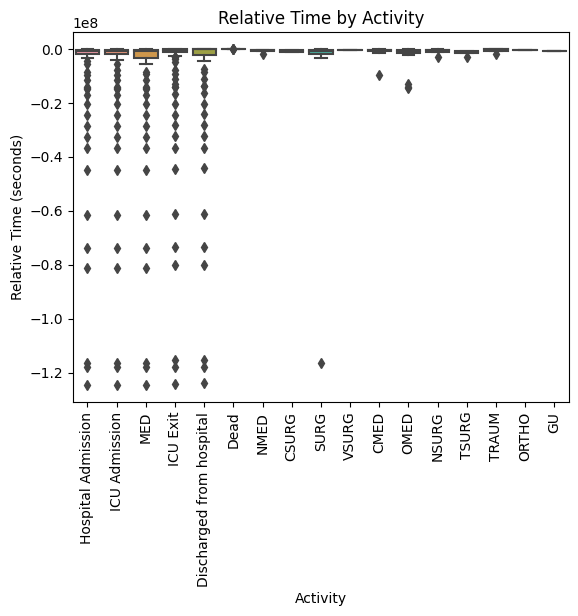

In [190]:
# Creaing a box plot of relative time by activity
sns.boxplot(x='activity', y='relativetime_s', data=final_event_log)
plt.xlabel('Activity')
plt.ylabel('Relative Time (seconds)')
plt.title('Relative Time by Activity')
plt.xticks(rotation=90)
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_2592\3328593627.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gantt_data['activity_duration'] = gantt_data['caseend'] - gantt_data['casestart']
C:\Users\Acer\AppData\Local\Temp\ipykernel_2592\3328593627.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gantt_data['activity_duration_s'] = gantt_data['activity_duration'].dt.seconds + 86400 * gantt_data['activity_duration'].dt.days


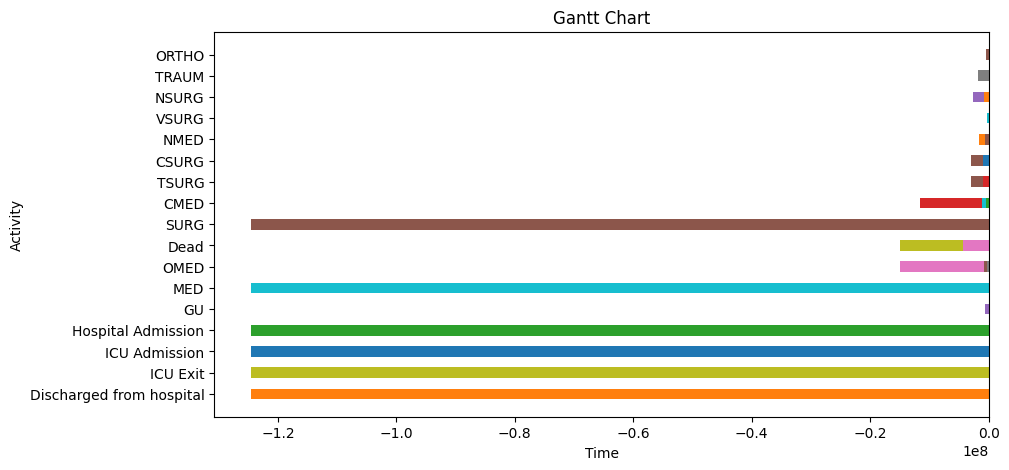

In [186]:
# Sequence and duration of activities in the process
import matplotlib.pyplot as plt
import pandas as pd

# Data for Gantt chart
gantt_data = final_event_log[['activity', 'casestart', 'caseend']]
gantt_data['activity_duration'] = gantt_data['caseend'] - gantt_data['casestart']
gantt_data['activity_duration_s'] = gantt_data['activity_duration'].dt.seconds + 86400 * gantt_data['activity_duration'].dt.days

# Sorting the data by case start time
gantt_data = gantt_data.sort_values('casestart')

# Creating the Gantt chart
fig, ax = plt.subplots(figsize=(10, 5))

for index, row in gantt_data.iterrows():
    ax.barh(row['activity'], width=row['activity_duration_s'], left=row['casestart'], height=0.5)

ax.set_xlabel('Time')
ax.set_ylabel('Activity')
ax.set_title('Gantt Chart')
plt.show()


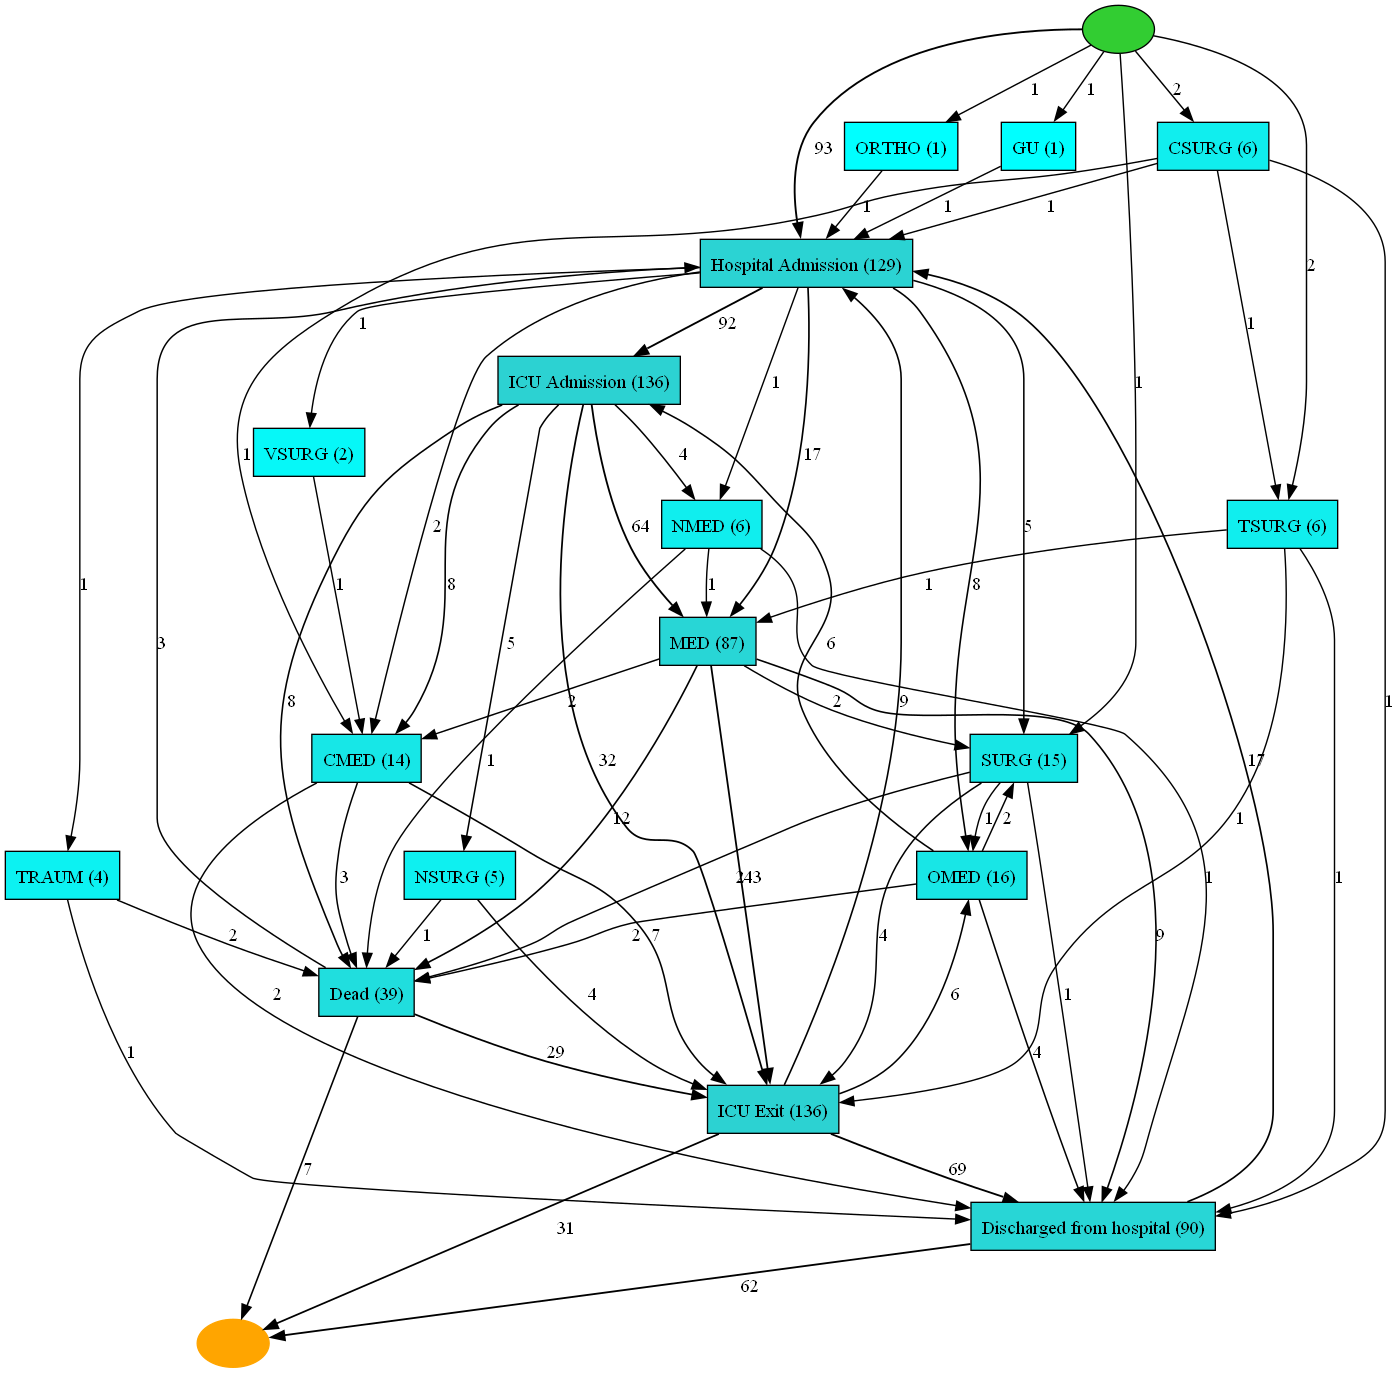

In [158]:
# Using the heuristics miner algorithm
import pm4py
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# MApping the columns to apply the mining algorithms
event_log = final_event_log.rename(columns= {
    'subject_id': 'case:concept:name',
    'activity': 'concept:name',
    'timestamp': 'time:timestamp'
})


# Heuristics miner algorithm
heu_net = heuristics_miner.apply_heu(event_log)

# Visualising the model
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

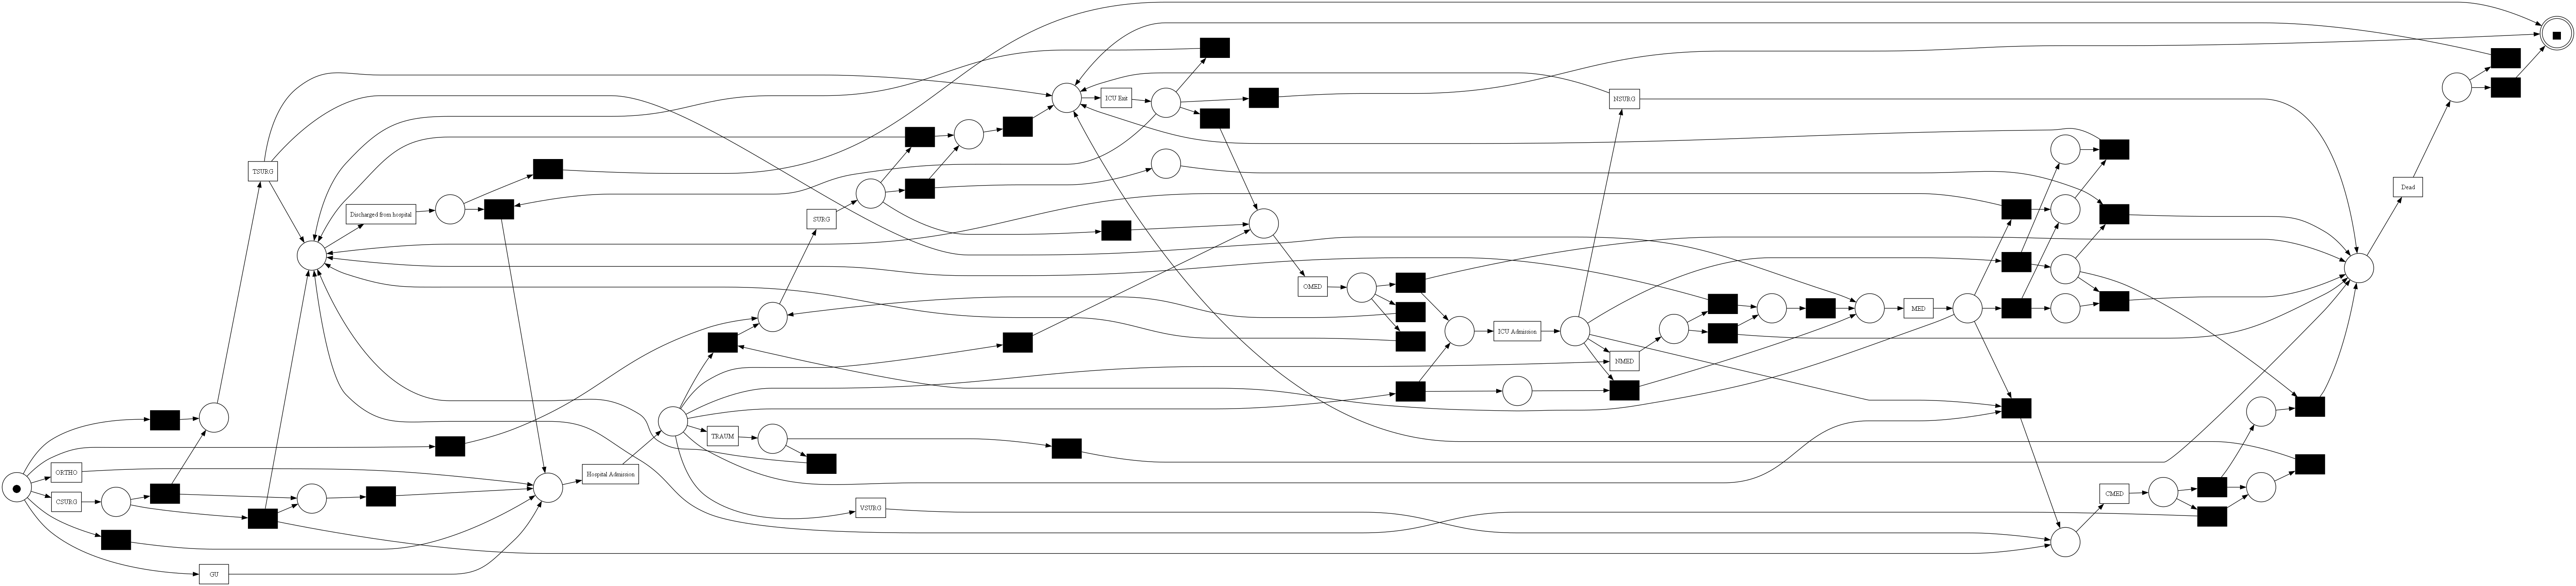

In [174]:
net, im, fm = heuristics_miner.apply(log)
# Petri net visualisation
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)